# Aplicación de algoritmo RollingBall

En este script se pretende replicar la experiencia con el algoritmo rollingball del paquete [baseline] de R.

Se incorporan consignas de **GridSearch** para evaluar los distintos pasos en un rango determinado de parámetros

Inicialmente se deben tener instalados los paquetes necesarios para el procesamiento de las imágenes.

Este paso puede **omitirse** si ya se encuentra instalado.

In [1]:
install.packages("ggplot2")
install.packages("imager")
install.packages("mixtools")
install.packages("baseline")
install.packages("Matrix")

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)



In [2]:
install.packages("rgdal")
install.packages("plotly")
#install.packages("EcoGenetics")

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)



In [3]:
install.packages("BiocManager")
BiocManager::install("EBImage")

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Bioconductor version 3.8 (BiocManager 1.30.10), R 3.5.2 (2018-12-20)

Installing package(s) 'EBImage'

Installation path not writeable, unable to update packages: boot, cluster,
  foreign, KernSmooth, MASS, Matrix, mgcv, nlme, rpart, survival

Old packages: 'callr', 'cli', 'curl', 'data.table', 'dendextend', 'igraph',
  'IRkernel', 'multcomp', 'plyr', 'RcppArmadillo', 'roxygen2', 'rversions',
  'segmented', 'testthat'



Incorporamos las dependencias necesarias

In [4]:
library(mixtools)
library(baseline)
library(ggplot2)
library(imager)
library(Matrix)

library("EBImage")

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



Attaching package: ‘baseline’


The following object is masked from ‘package:stats’:

    getCall


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:mixtools’:

    depth


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image



Attaching package: ‘EBImage’


The following objects are masked from ‘package:imager’:

    channel, dilate, display, erode, resize, watershed




El primer paso consiste en cargar la imagen en una variable. La representación de la imagen está en el espacio de color RGB.

In [5]:
#Load and plot the RGB file
#data.file <- '/mnt/usb-WD_Elements_25A2_575852314531383859503438-0:0-part1/CHB/PASANTIA/imagenes_forestal/data/DJI_0805.jpg'
data.file <- '../imagenes_forestal/data/original_referencia.jpg'
im <- load.image(data.file)

A los efectos de procesar la porción central de la imagen y reducir así los efectos de distorsión de perspectiva por desvío de la línea vertical nadir-cenit, además de proporcionar una reducción del tamaño de la imagen, se realiza un recorte de la imagen en 300 x 300 píxeles.
Una vez que la imagen se encuentra cargada en la variable, es posible imprimir el gráfico con la función <code>plot</code>

La imagen con la que se trabaja fue obtenida por medio de un dron que sobrevolaba la [reserva biósfera Yaboty](https://sib.gob.ar/area/MISIONES*YB*YABOTY), a una altitud aproximada de 600 metros. La resolución de la imagen original es de 12 Mpixels (4000 x 3000), pero fue reducida a una resolución de 1000 x 750 pixels para aliviar la carga de procesamiento.

Teniendo en cuenta los datos del vuelo, de la [cámara](https://www.dji.com/phantom-4/info) y del terreno, podemos hallar que la resolución espacial de la fotografía aérea es de 0,5 metro por pixel, aproximadamente (esto teniendo en cuenta que la imagen original fue reducida en su resolución original de 4000 x 3000 pixeles a 1000 x 750 pixeles)


Una observación en la imagen del recorte de la copa permite estimar el tamaño que abarca la copa en 80 píxeles. Este dato será usado en los parámetros de los filtro implementados.

Para procesar la imagen, debe ser convertida al espacio de color [HSL](https://es.wikipedia.org/wiki/Modelo_de_color_HSL), del cual se tomará la componente **L** de luminosidad.

In [6]:
#GPerforms the conversion of the image from RGB to HSL colorspace
im_hsl <- RGBtoHSL(im)

Se extrae la componente L de la imagen HSL y se la almacena en una variable

In [7]:
#Extracts the L component from HSL colorspace image
#im_L <- im_hsl[200:500,200:500,3]
im_L <- im_hsl[,,3]

In [8]:
param <- normalmixEM(as.vector(im_L))

number of iterations= 85 


# 3. Primer identificación de objetos oscuros


**ENTRADA**: escala de grises (canal L)

**SALIDA**: sombras interarbóreas intensificadas

Se lleva a cabo una primera identificación de objetos oscuros, definiéndolos como los que tienen un valor por debajo de la media en la distribución de grises en brechas (hallada mediante el algoritmo <code>normalmixEM</code>), y a éstos se los iguala a cero.


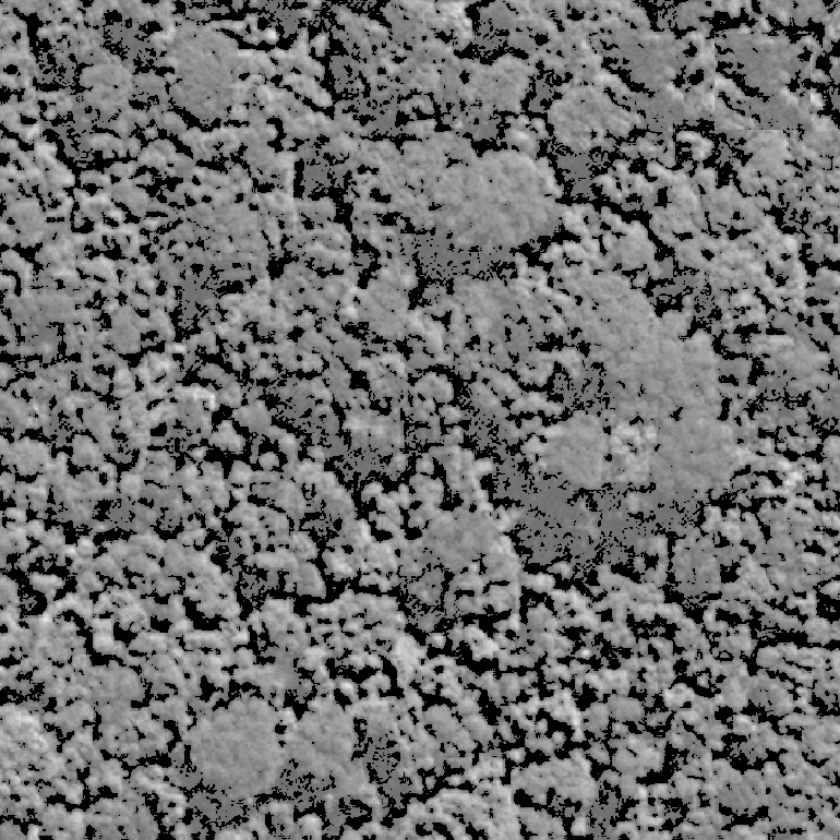

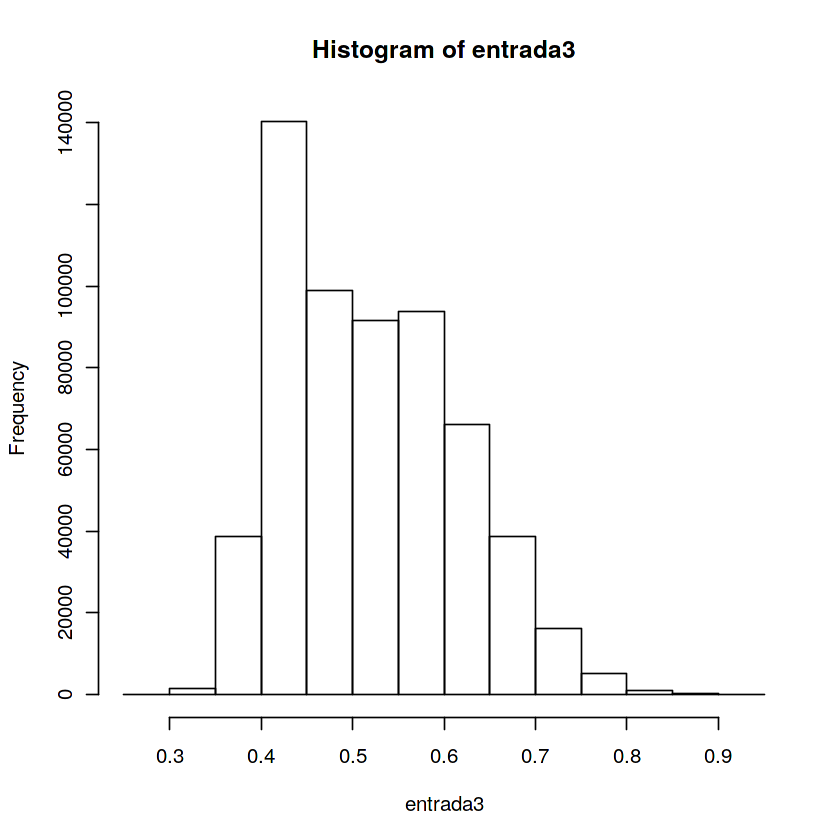

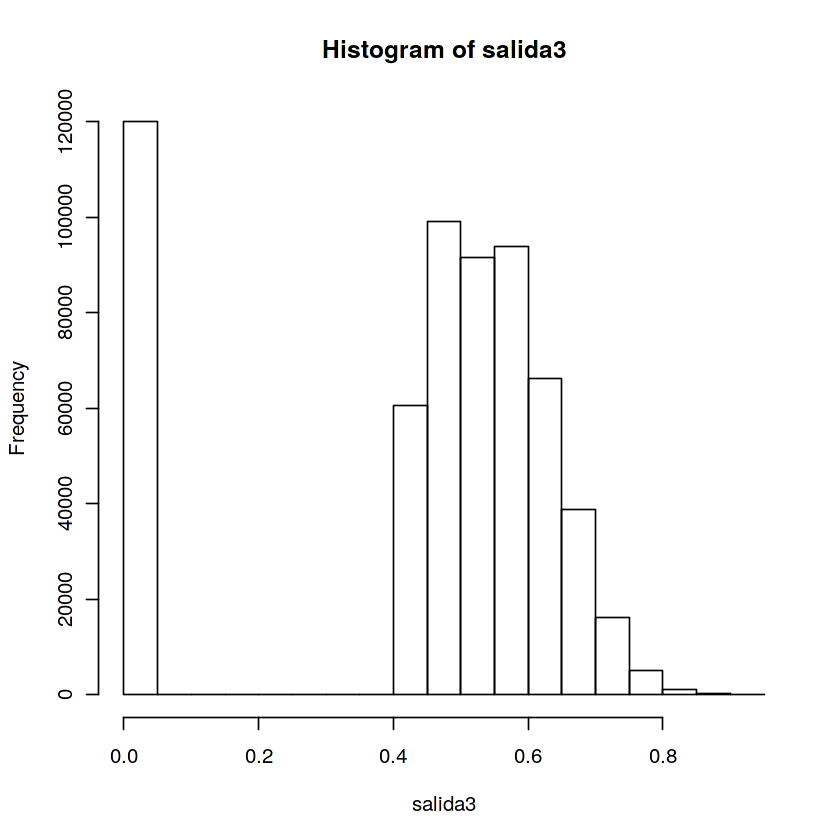

In [9]:
entrada3 <- im_L
#values of image that are lower than mean are set to 0
salida3 <- (entrada3>param$mu[1])*entrada3
display(salida3)
hist(entrada3)
hist(salida3)

# 4. Relleno de sombras en grandes copas de árboles



**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen filtrada

La imagen en escala de grises (canal L) se invierte y se le suma el máximo valor de la escala de grises. Esto es comparable con una imagen negativa. Se computan dos imágenes baseline mediante un filtro RollingBall con un radio de tres píxeles. Las imágenes obtenidas se vuelven a invertir, y los valores máximos de la escala de grises se usaron para obtener la imagen final suavizada.


In [10]:
gridSearch <- function(fun, im, a) { #Función definida para el procesamiento del paso 4 en un rango determinado de uno de los parámetros;
    #un argumento es la función, que es específica del paso 4, otro es la imagen a ser procesada y el tercer argumento es el parámetro, correspondiente al ancho de ventana del filtro rolling ball
  
    len_a <- length(a)
    len_im <- dim(im)
    
    #result_array <- array(len_im,len_a,len_b)
    result_array <- array(0, dim=c(len_im[1],len_im[2],len_a))
    #k <- 1 # ka se usa como índice de la imagen resultado
    for (i in c(1:len_a)){
            result_array[,,i] <- fun(im,a[i])
            #k <- k + 1
    }
    
    return (result_array)
    }

In [11]:
paso4 <- function(im,ws){
    entrada4 <- im
    #inversion of grayscale image and addition of maximum grayscale value
    im_L_inv <- entrada4*(-1)+max(entrada4)
    window_size <- ws
    #both baselines bline1 and bline2 are computed considering one input as inverted image and the other input as transposed inverted image
    bline1 <- baseline(t(im_L_inv),wm=window_size, ws=window_size, method='rollingBall')
    bline2 <- baseline(im_L_inv,wm=window_size, ws=window_size, method='rollingBall')
    #smooth image
    im_smooth <- pmax(t(bline1@baseline)*(-1),(bline2@baseline)*(-1))
    salida4 <- im_smooth
    return (salida4)
}

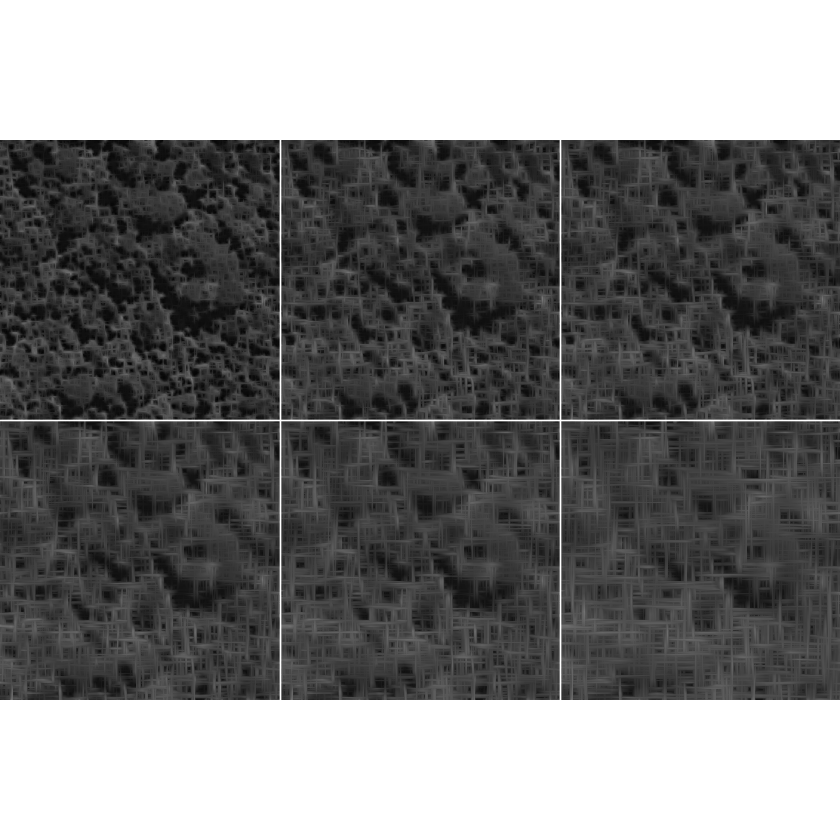

In [12]:
imagenes <- gridSearch(paso4,im_L,c(6,10,12,15,18,24))

display(imagenes+max(-imagenes), all = TRUE)


# 5. Identificar y rellenar huecos en grandes copas de árboles



**ENTRADA**: 

**SALIDA**: 


Se identifican las copas con un diámetro mayor a 15 píxeles, que corresponde a 7,5 metros, mediante una transformación top hat. Para ello se utiliza un elemento estructurante circular con un diámetro de 15 píxeles. El resultado de esto es una máscara binaria que contiene solamente las copas de diámetro mayor a 15 píxeles. Los huecos son rellenados entonces con los valores de escala de grises obtenidos anteriormente.

In [17]:
gridSearch2 <- function(fun, im,im2,a) { #Función definida para el procesamiento del paso 5 en un rango determinado de uno de los parámetros;
    #un argumento es la función, que es específica del paso 5, otro es la imagen a ser procesada, el tercer argumento es la imagen de salida del paso 4, y el cuarto argumento correspondiente al radio en píxeles
  
    len_a <- length(a)
    len_im <- dim(im)
    
    #result_array <- array(len_im,len_a,len_b)
    result_array <- array(0, dim=c(len_im[1],len_im[2],len_a))
    #k <- 1 # k se usa como índice de la imagen resultado
    for (i in c(1:len_a)){
            result_array[,,i] <- fun(im,im2,a[i])
            #k <- k + 1
    }
    
    return (result_array)
    }

In [58]:
paso5 <- function(im,im2,radio){ #dos de los argumentos a ser pasados son imágenes, y uno es el parámetro radio
    entrada5 <- salida3
im2 <- imagenes[,,3]
    #Top hat
    #Structuring element consists in a circular shape of determined radius
    #radio <- 14 #radius of 7 pixels, corresponding to crown diameter; con 14 se da un mejor resultado usando la imagen original de referencia
    mask <- px.circle(radio)

    abertura <- mopening(as.cimg(entrada5),mask,real_mode = FALSE)
    t_hat <- as.cimg(entrada5) - abertura
    abertura <- abertura>0
    #display(entrada5)
    maskara <- abertura[,,1,1]
    salida5 <- (maskara*im2)*(-2)
    #hist(salida5)

    #display(salida5)
    salida5 <- ((!maskara&entrada5)*entrada5+salida5)
    #display(salida5)
    #hist(entrada5)
    #hist(salida5)
        return (salida5)

    }

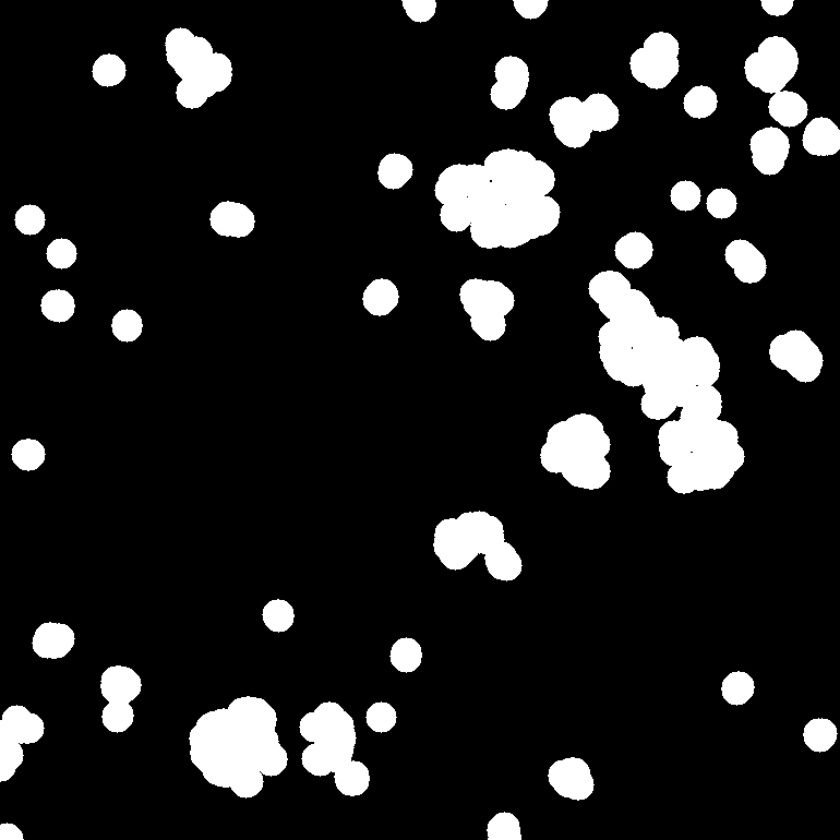

In [56]:
display(paso5(salida3,imagenes[,,3],14))

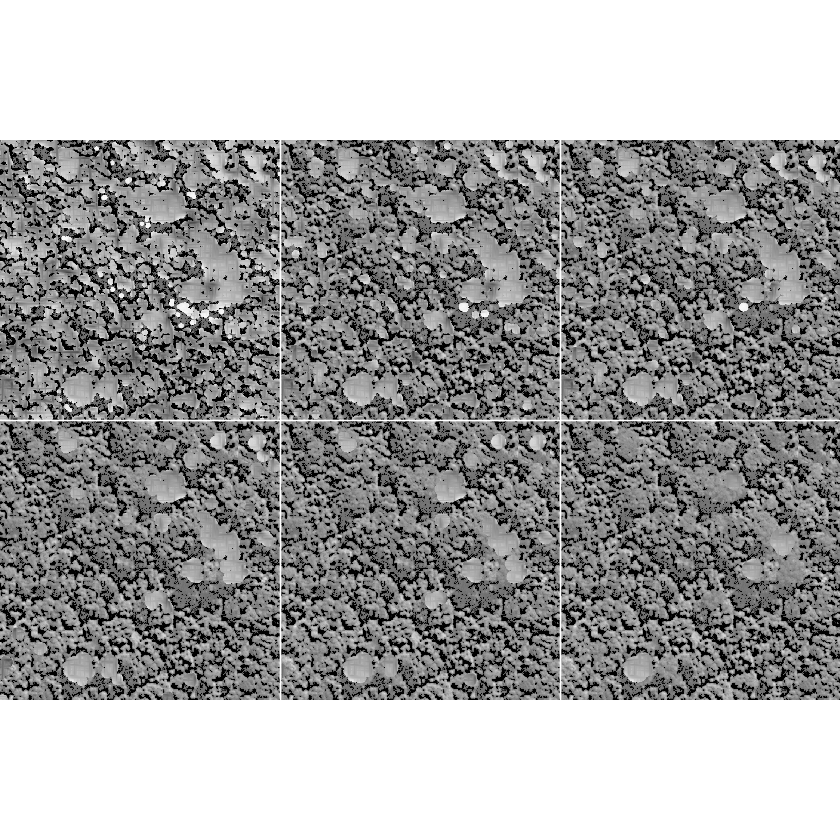

In [59]:
imagenes2 <- gridSearch2(paso5,salida3,imagenes[,,3],c(6,10,12,15,18,24))

display(imagenes2, all = TRUE)


# 6. Segunda identificación de objetos oscuros¶

**ENTRADA**: salida de la etapa 5

**SALIDA**: imagen de copas sin sombra interna

Bajo la asunción de que la mayoría de los píxeles sombreados de las copas fueron removidos, se lleva a cabo una identificación final de píxeles oscuros, los cuales son definidos como los píxeles de escala de grises que son menores al 99° percentil en la distribuciones en huecos, y se los iguala a cero.

In [36]:
paso6 <- function(im,percentil) {
    entrada6 <- salida5
#a normal distribution (n_gaps) is generated, using the parameters that were found with normalmixEM (eg. the media and standard deviation)
n_gaps <- rnorm(length(entrada6), mean = param$mu[1], sd = param$sigma[1])
noventaynueve <- quantile(n_gaps,percentil)
salida6 <- (!(entrada6[,]<noventaynueve))*entrada6
return(salida6)
}


# 7. Hallar pequeños huecos en grandes copas¶

**ENTRADA**: escala de grises (im_L)

**SALIDA**: imagen binaria

Las copas grandes poseen píxeles sueltos de sombra que deben ser rellenados para luego calcular la distancia de los píxeles al borde (o sea los píxeles oscuros). Mediante una ventana de 7 x 7 píxeles se calcula la ocurrencia de valores distintos de cero entorno a cada píxel, los cuales poseen una distribución bimodal. Los huecos en las copas se definen como aquellos que están por encima del 75° percentil. Al final de esta etapa se identifican tres clases de píxel: los de sombra entre árboles, los no sombreados en las copas y los aislados de sombras en las copas. Con estas tres clases se compone una máscara binaria con 0 para píxeles fuera de copas y 1 para los interiores de copas.


In [19]:
entrada7 <- salida6
ti <- proc.time()
mat_riz<-cbind(0,0,0,entrada7,0,0,0) #se rellenan tres columnas con ceros por izquierda y por derecha
mat_riz<-rbind(0,0,0,mat_riz,0,0,0) #se rellenan tres filas con ceros por arriba y por abajo
MNZ <- entrada7*0 #MNZ es una matriz de la misma dimensión que mat_riz completa con ceros

for (i in 4:dim(entrada7)[1]+2) { #i es el índice que recorre las columnas
   for (j in 4:dim(entrada7)[2]+2) { #j es el índice que recorre las filas
       a <- i-3
       b <- i+3
       c <- j-3
       d <- j+3
       ventana <- mat_riz[a:b,c:d]
       MNZ[i-2,j-2] <- nnzero(ventana)
   }
   
 }
(delta <- proc.time()-ti)

   user  system elapsed 
 24.126   0.000  24.134 

En el artículo de referencia se toma un valor de cuantil del 75%; se ha probado con un valor que se acerca al 94% percentil, ya que ahí el resultado es una matriz nula (todo negro)

75% 
0.6078431

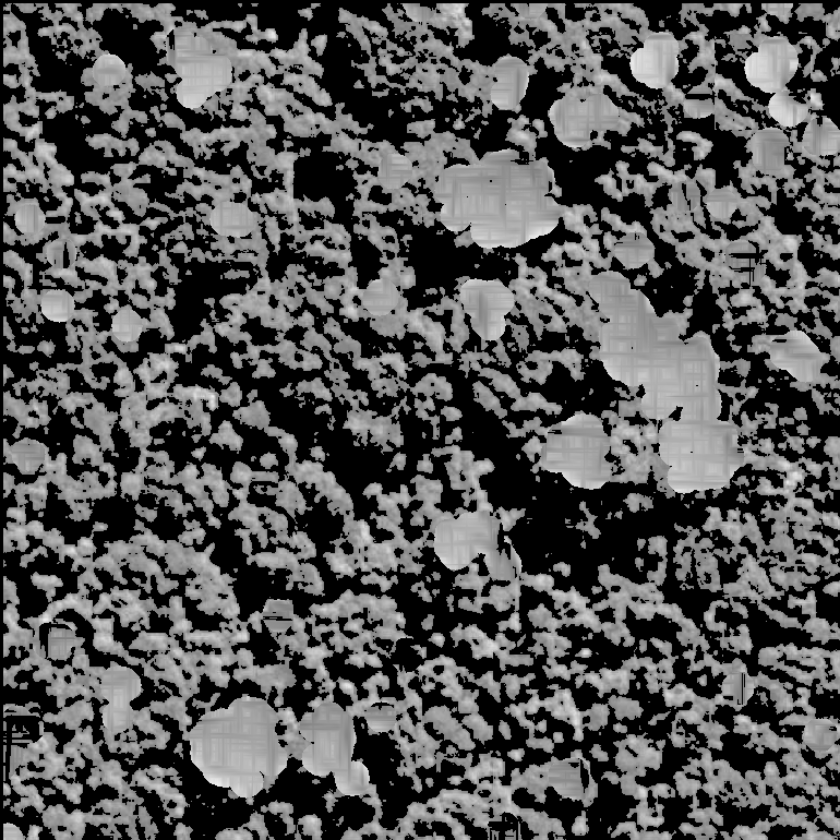

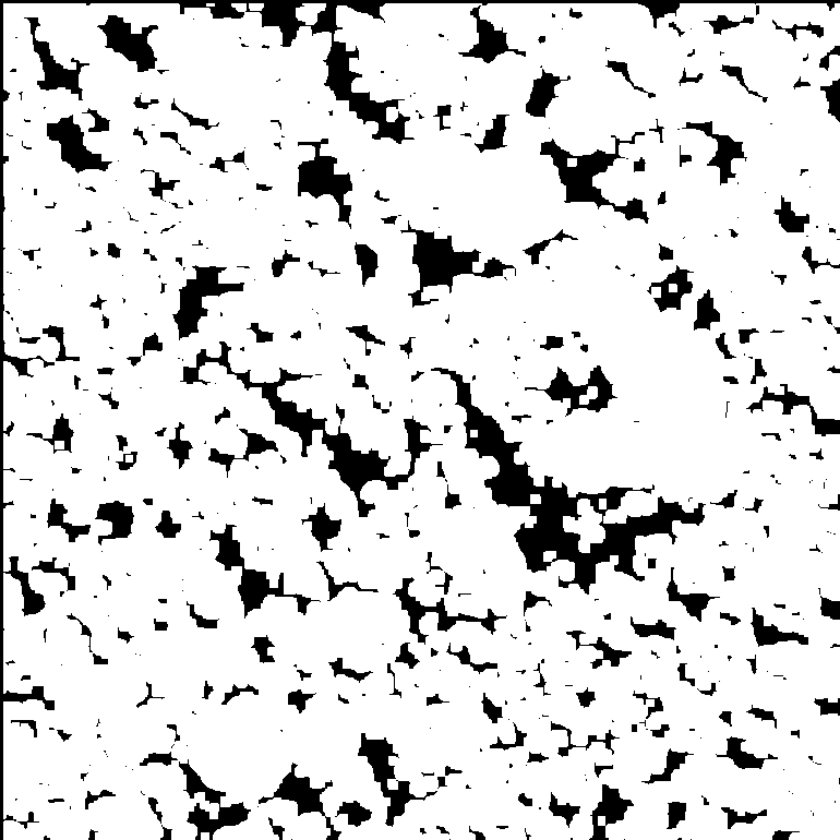

In [20]:
(setentaycinco <- quantile(entrada7,.75))
#hist(MNZ)
#hist(entrada7)
huecos_copas <- (MNZ>setentaycinco)*entrada7
salida7 <- huecos_copas
display(huecos_copas)
mascara7 <- MNZ>setentaycinco
display(mascara7)
display(MNZ)

# 8. Homogenización de valores de escala de grises en grandes copas

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Para homogenizar los valores en grises en grandes copas, se calcula la distancia mínima entre valores distinto de cero y el valor de cero de la máscara precedente. Todos los píxeles con distancia mayor a 7 se identifican como grandes árboles, y se rellenan con el valor de la media de los cuatro valores mayores dentro de una ventana de 7 x 7 píxeles.



[1] 0.55

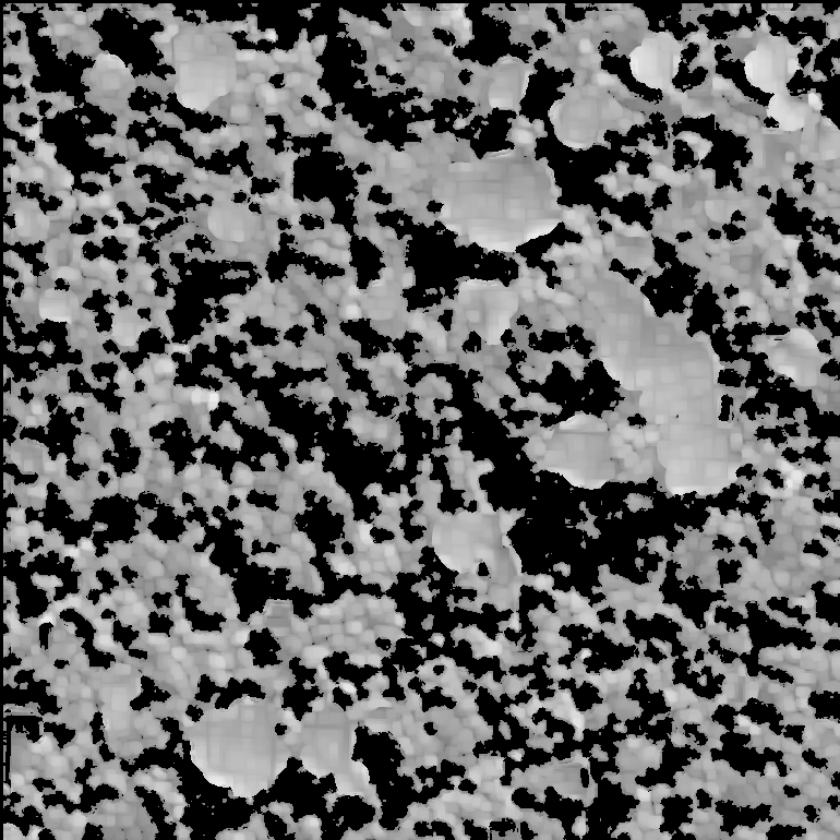

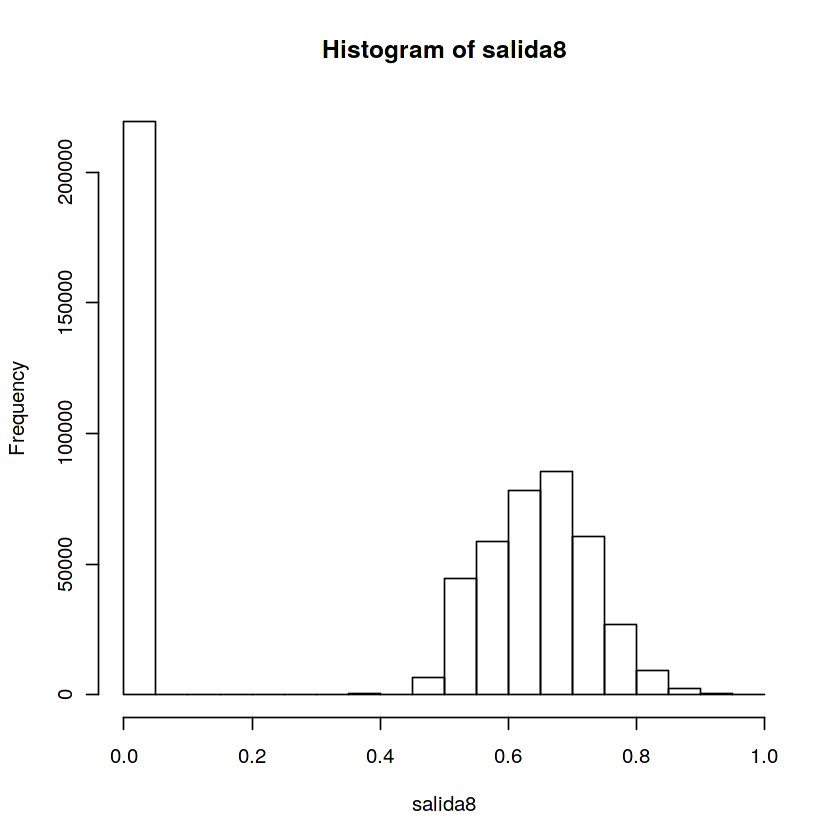

In [21]:
entrada8 <- salida7
im_dist <- distmap(MNZ)
#display(im_dist)

dist_min <- 7 #distancia mínima 7 píxeles
mat_riz<-cbind(0,0,0,entrada8,0,0,0) #se rellenan tres columnas con ceros por izquierda y por derecha
mat_riz<-rbind(0,0,0,mat_riz,0,0,0)
for (i in 4:dim(entrada8)[1]+2) { #i es el índice que recorre las columnas
   for (j in 4:dim(entrada8)[2]+2) { #j es el índice que recorre las filas
       a <- i-3
       b <- i+3
       c <- j-3
       d <- j+3
       if (im_dist[i-2,j-2] > dist_min) {
            ventana <- mat_riz[a:b,c:d]
       media <- 0
       for (n in 1:4) {
           media <- max(ventana)/4 + media
           ventana[which.max(ventana)] <- 0
       }
       entrada8[i-2,j-2] <- media
       }
           
      
   }
   
 }
media
salida8 <- entrada8
display(salida8)
hist(salida8)

In [22]:
#x = readImage(system.file("images", "shapes.png", package="EBImage"))
#display(x)
#dx = distmap(x)
#display(dx/10, title='Distance map of x')

# 9. Extracción de copas antes de la segmentación

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Las copas con diámetro mayor a 3 metros se extraen mediante un filtro top bottom hat con elemento estructural cuadrado de 6 x 6 píxeles. A partir de esa imagen transformada, se aplica un umbral mayor a 0,001° percentil del filtro.



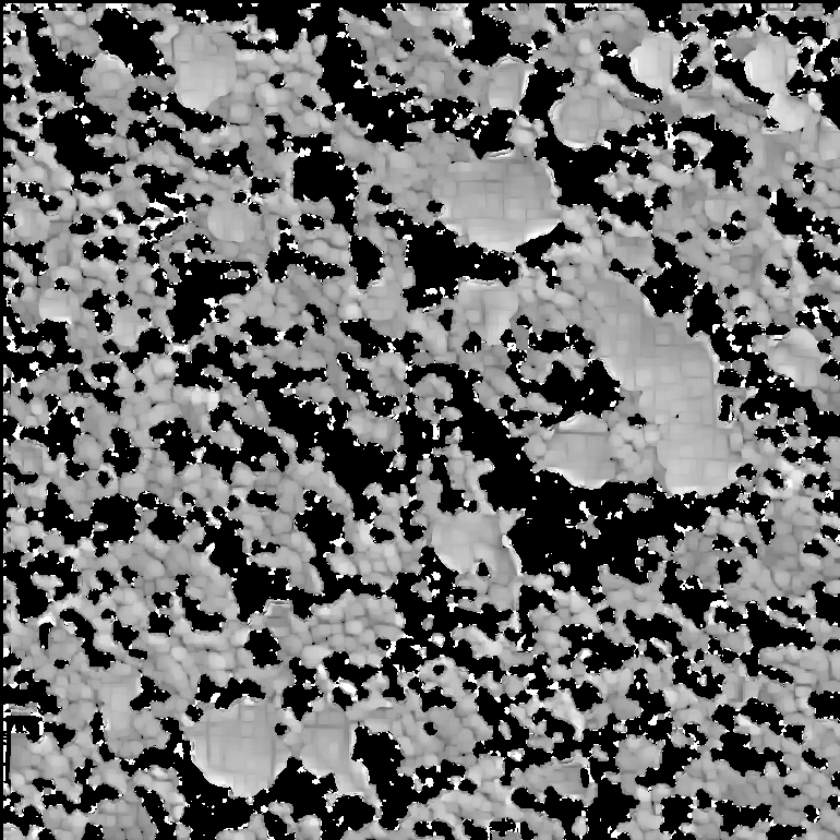

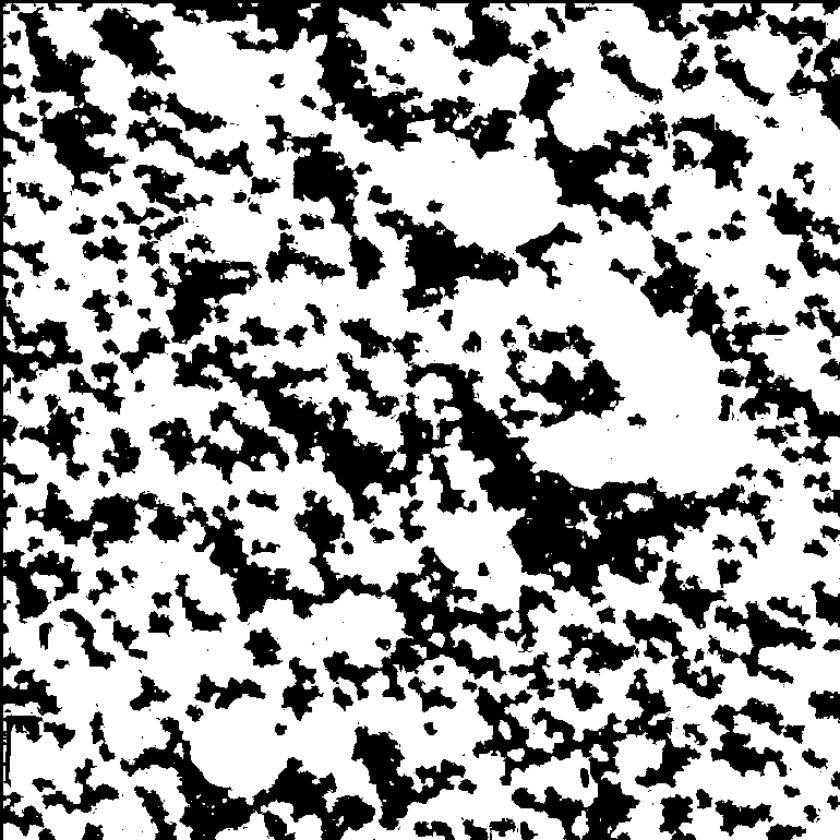

In [23]:
entrada9 <- salida8
#Top hat y bottom hat
mask <- imfill(6,6,val=1)
top_hat <- as.cimg(entrada9) - mopening(as.cimg(entrada9),mask)
bottom_hat <-  mclosing(as.cimg(entrada9),mask) - as.cimg(entrada9)
im_filt <- as.cimg(entrada9) + top_hat - bottom_hat
display(im_filt)
umbral <- 0.1
percentil <- quantile(im_filt,umbral)
salida9 <- (im_filt>percentil)
display(salida9)
#hist(salida9)


# 10. Delineación de copas individuales

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Se calcula la distancia entre valores cero y distinto de cero, es decir la distancia del píxel en la copa al borde. Procesando de manera separada por copas o grupos de copas, calculando las distancias de píxeles a los bordes. Luego se calcula el máximo local en una ventana cuadrada de la máxima distancia al borde del segmento. Para cada máximo local se genera una imagen mediante la dilatación entorno a su locación, con un tamaño que duplique el diámetro.

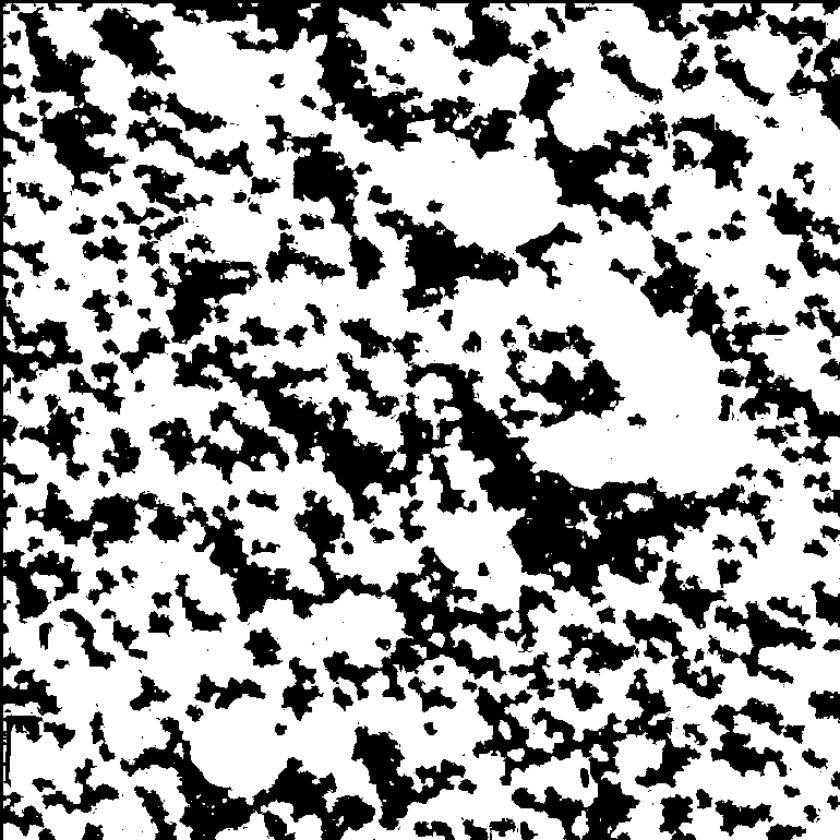

In [24]:
entrada10 <- salida9
distancia <- distmap(entrada10)
display(distancia)


# Conclusiones